
![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/DOCX_TO_TEXT.ipynb)

# **DOCX to Text**

## ***Example of extracting text from Microsoft DOCX documents***

## 🔎**Colab Setup** 

In [ ]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.0.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
! pip install spark-ocr==$OCR_VERSION\+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)



## **🔎Import OCR transformers**

In [2]:
import sparkocr
import sys
from pyspark.sql import SparkSession
from sparkocr import start
import base64
from sparkocr.transformers import *
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F
from sparkocr.enums import *
from sparkocr.utils import display_images, display_image

In [3]:
# Start spark
spark = sparkocr.start(secret=SPARK_OCR_SECRET, 
                       nlp_version=PUBLIC_VERSION
                       )


Spark version: 3.0.2
Spark NLP version: 3.4.4
Spark OCR version: 3.12.0



In [4]:
spark.conf.set("spark.sql.legacy.allowUntypedScalaUDF", True)
print(spark.conf.get("spark.sql.legacy.allowUntypedScalaUDF"))

true


## **🔎Read DOCX document as binary file**

In [5]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/streamlit_notebooks/ocr/data/Disposition_Checklist.docx

In [6]:
doc_example_df = spark.read.format("binaryFile").load("Disposition_Checklist.docx").cache()

In [7]:
doc_example_df

path,modificationTime,length,content
file:/content/Dis...,2022-06-09 09:02:...,299223,[50 4B 03 04 14 0...


## **🔎Preview document using DocToPdf and PdfToImage transformers**


    Image #0:
    Origin: file:/content/Disposition_Checklist.docx
    Resolution: 300 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


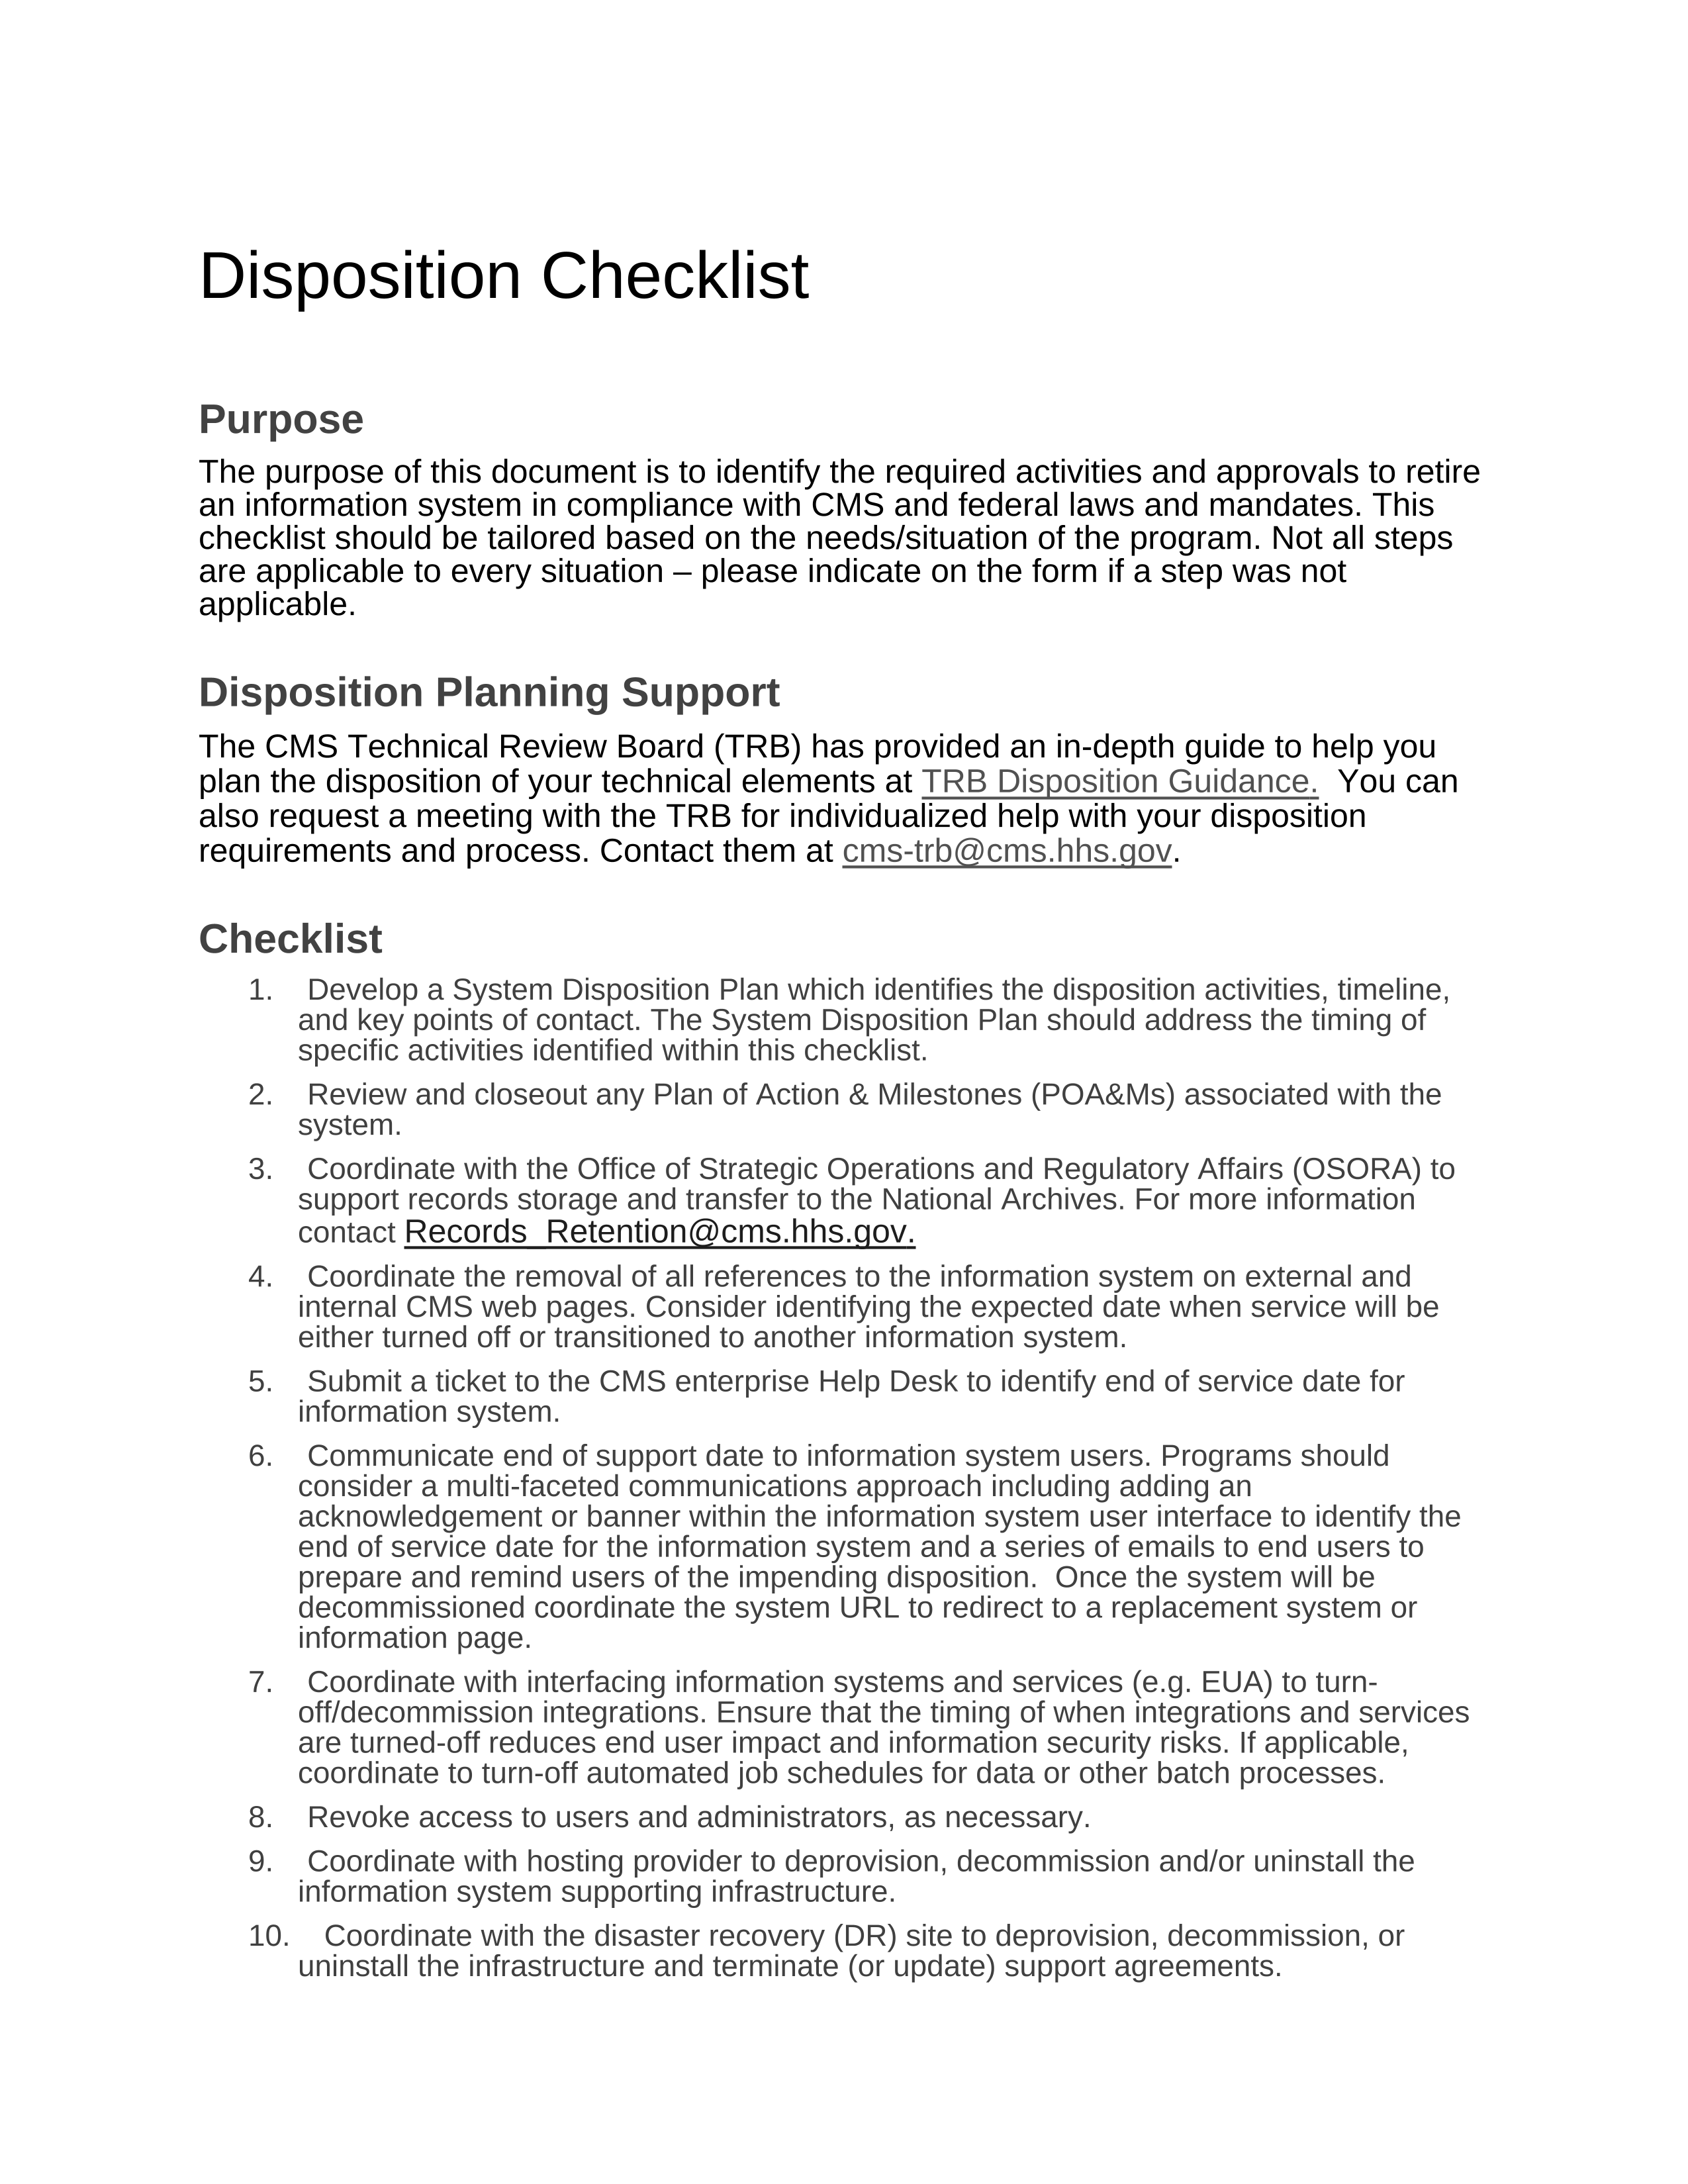


    Image #0:
    Origin: file:/content/Disposition_Checklist.docx
    Resolution: 300 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


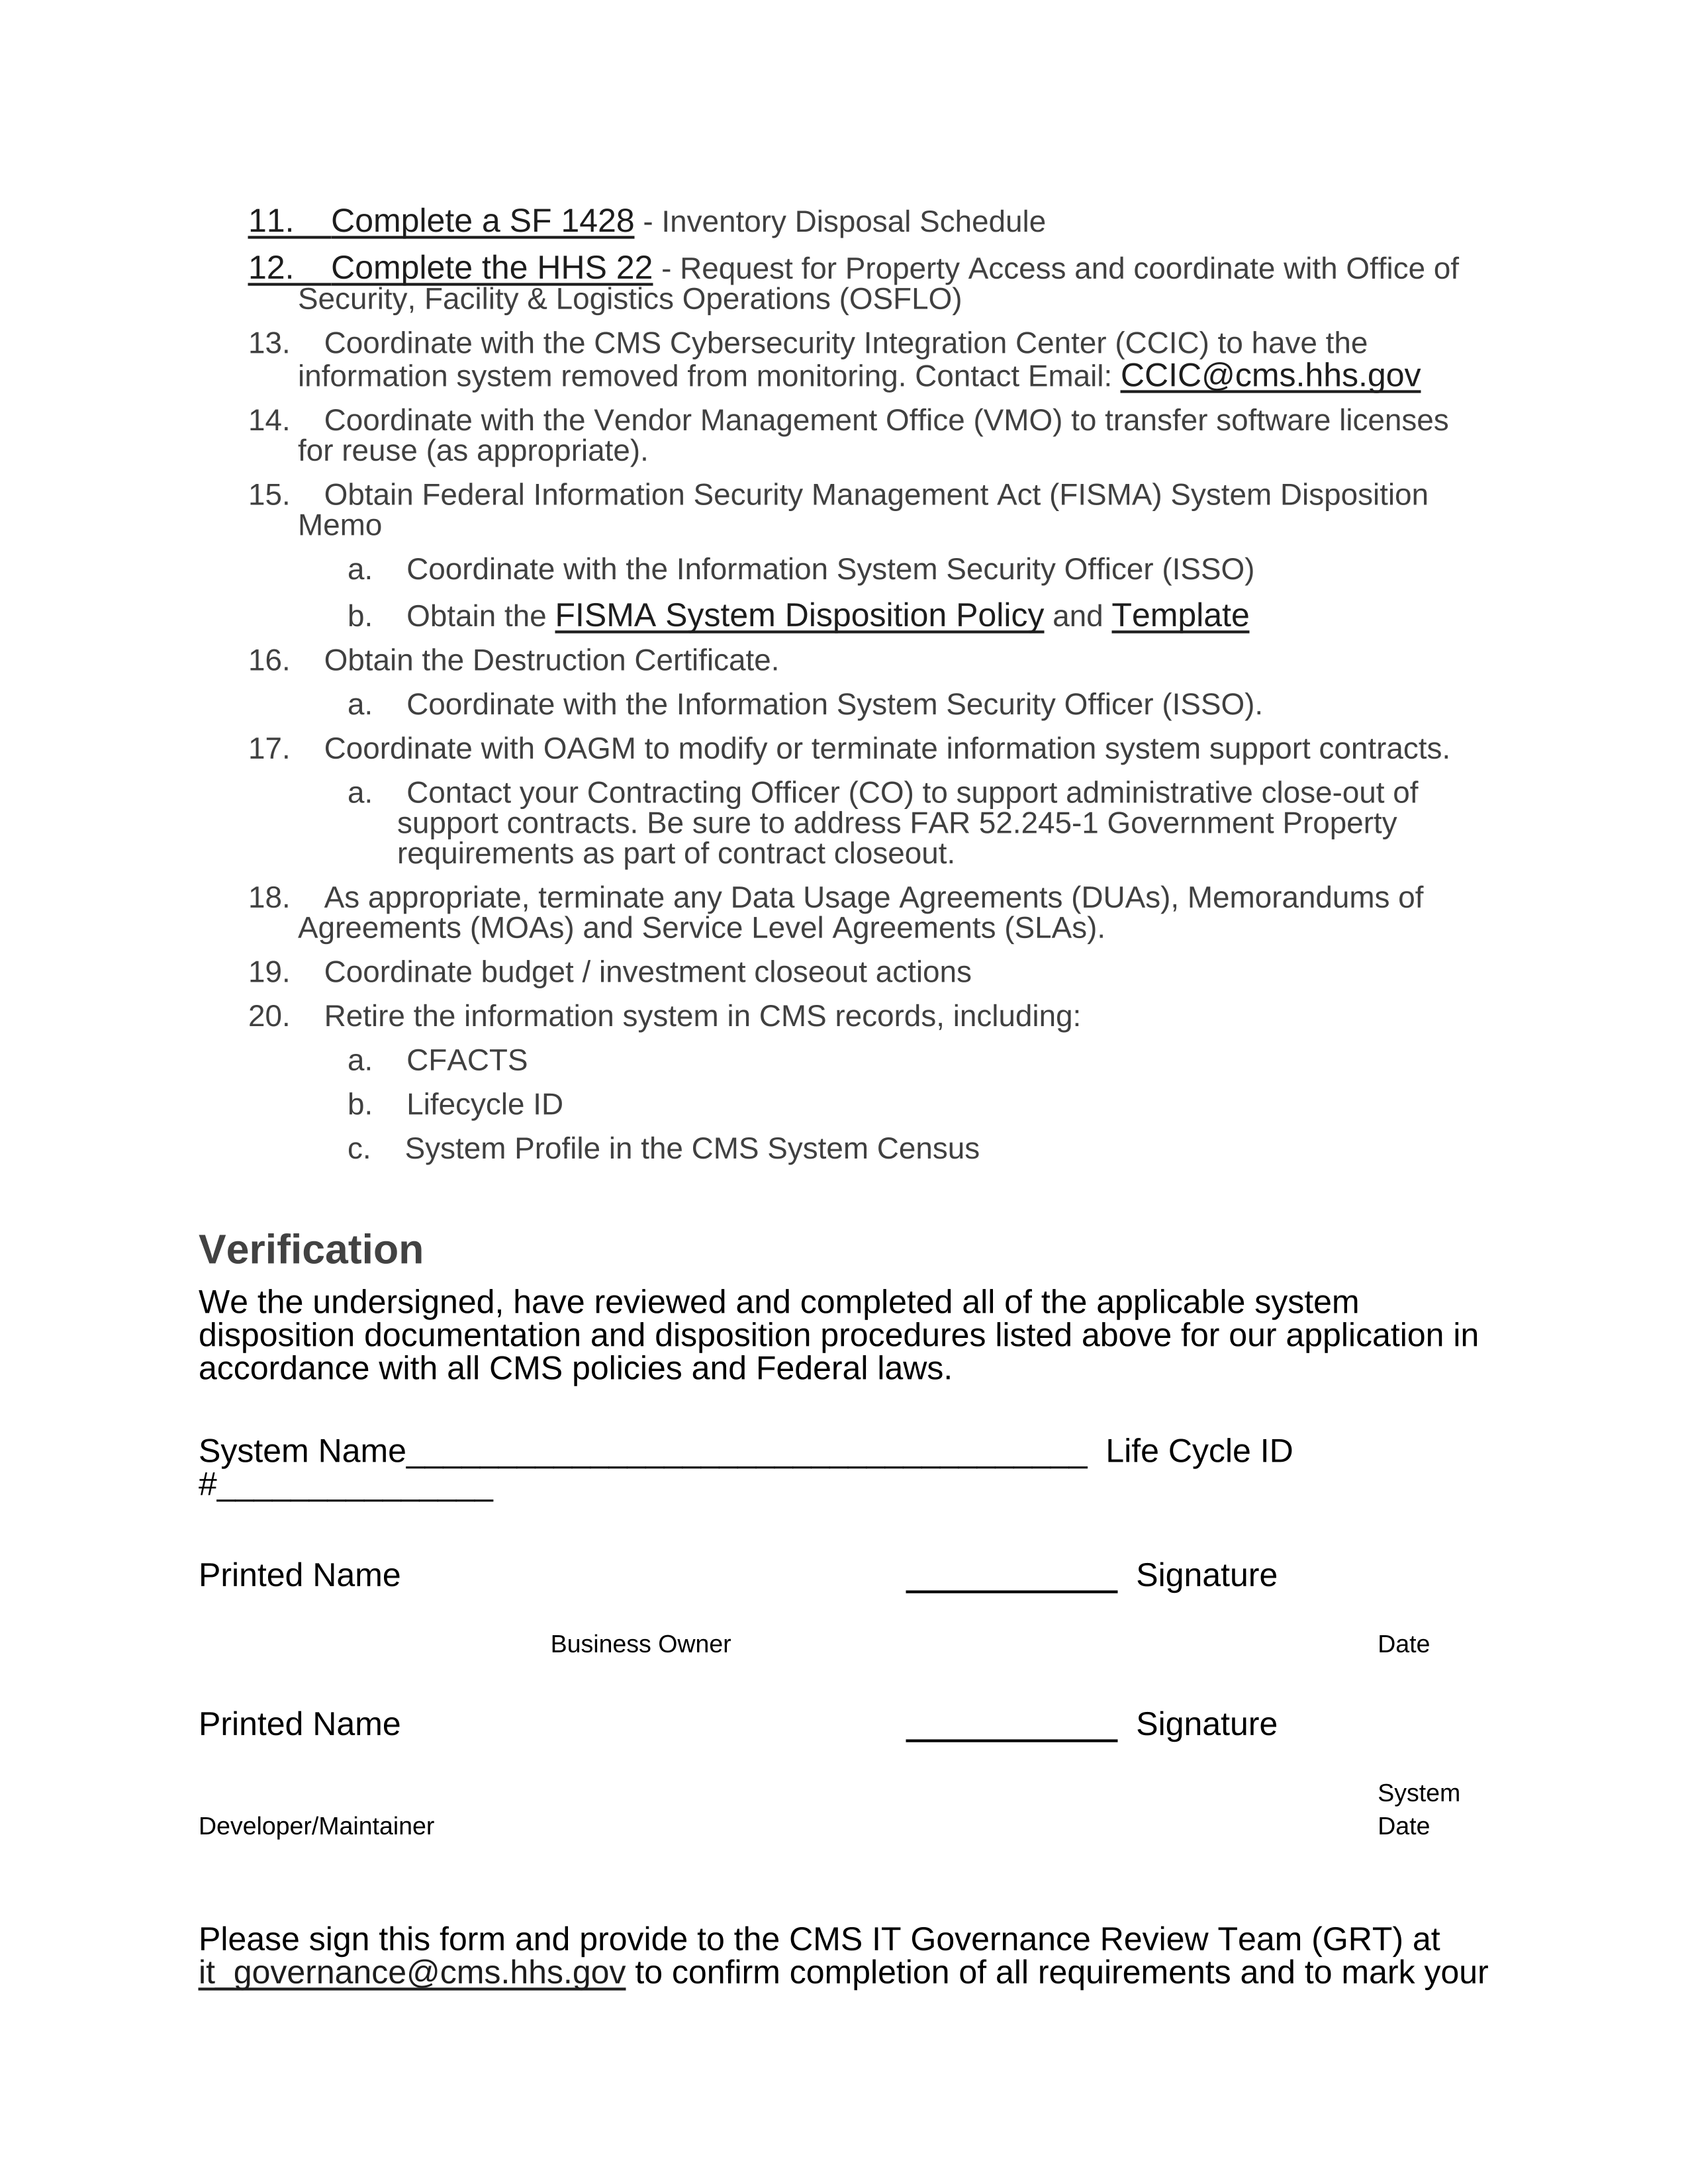


    Image #0:
    Origin: file:/content/Disposition_Checklist.docx
    Resolution: 300 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


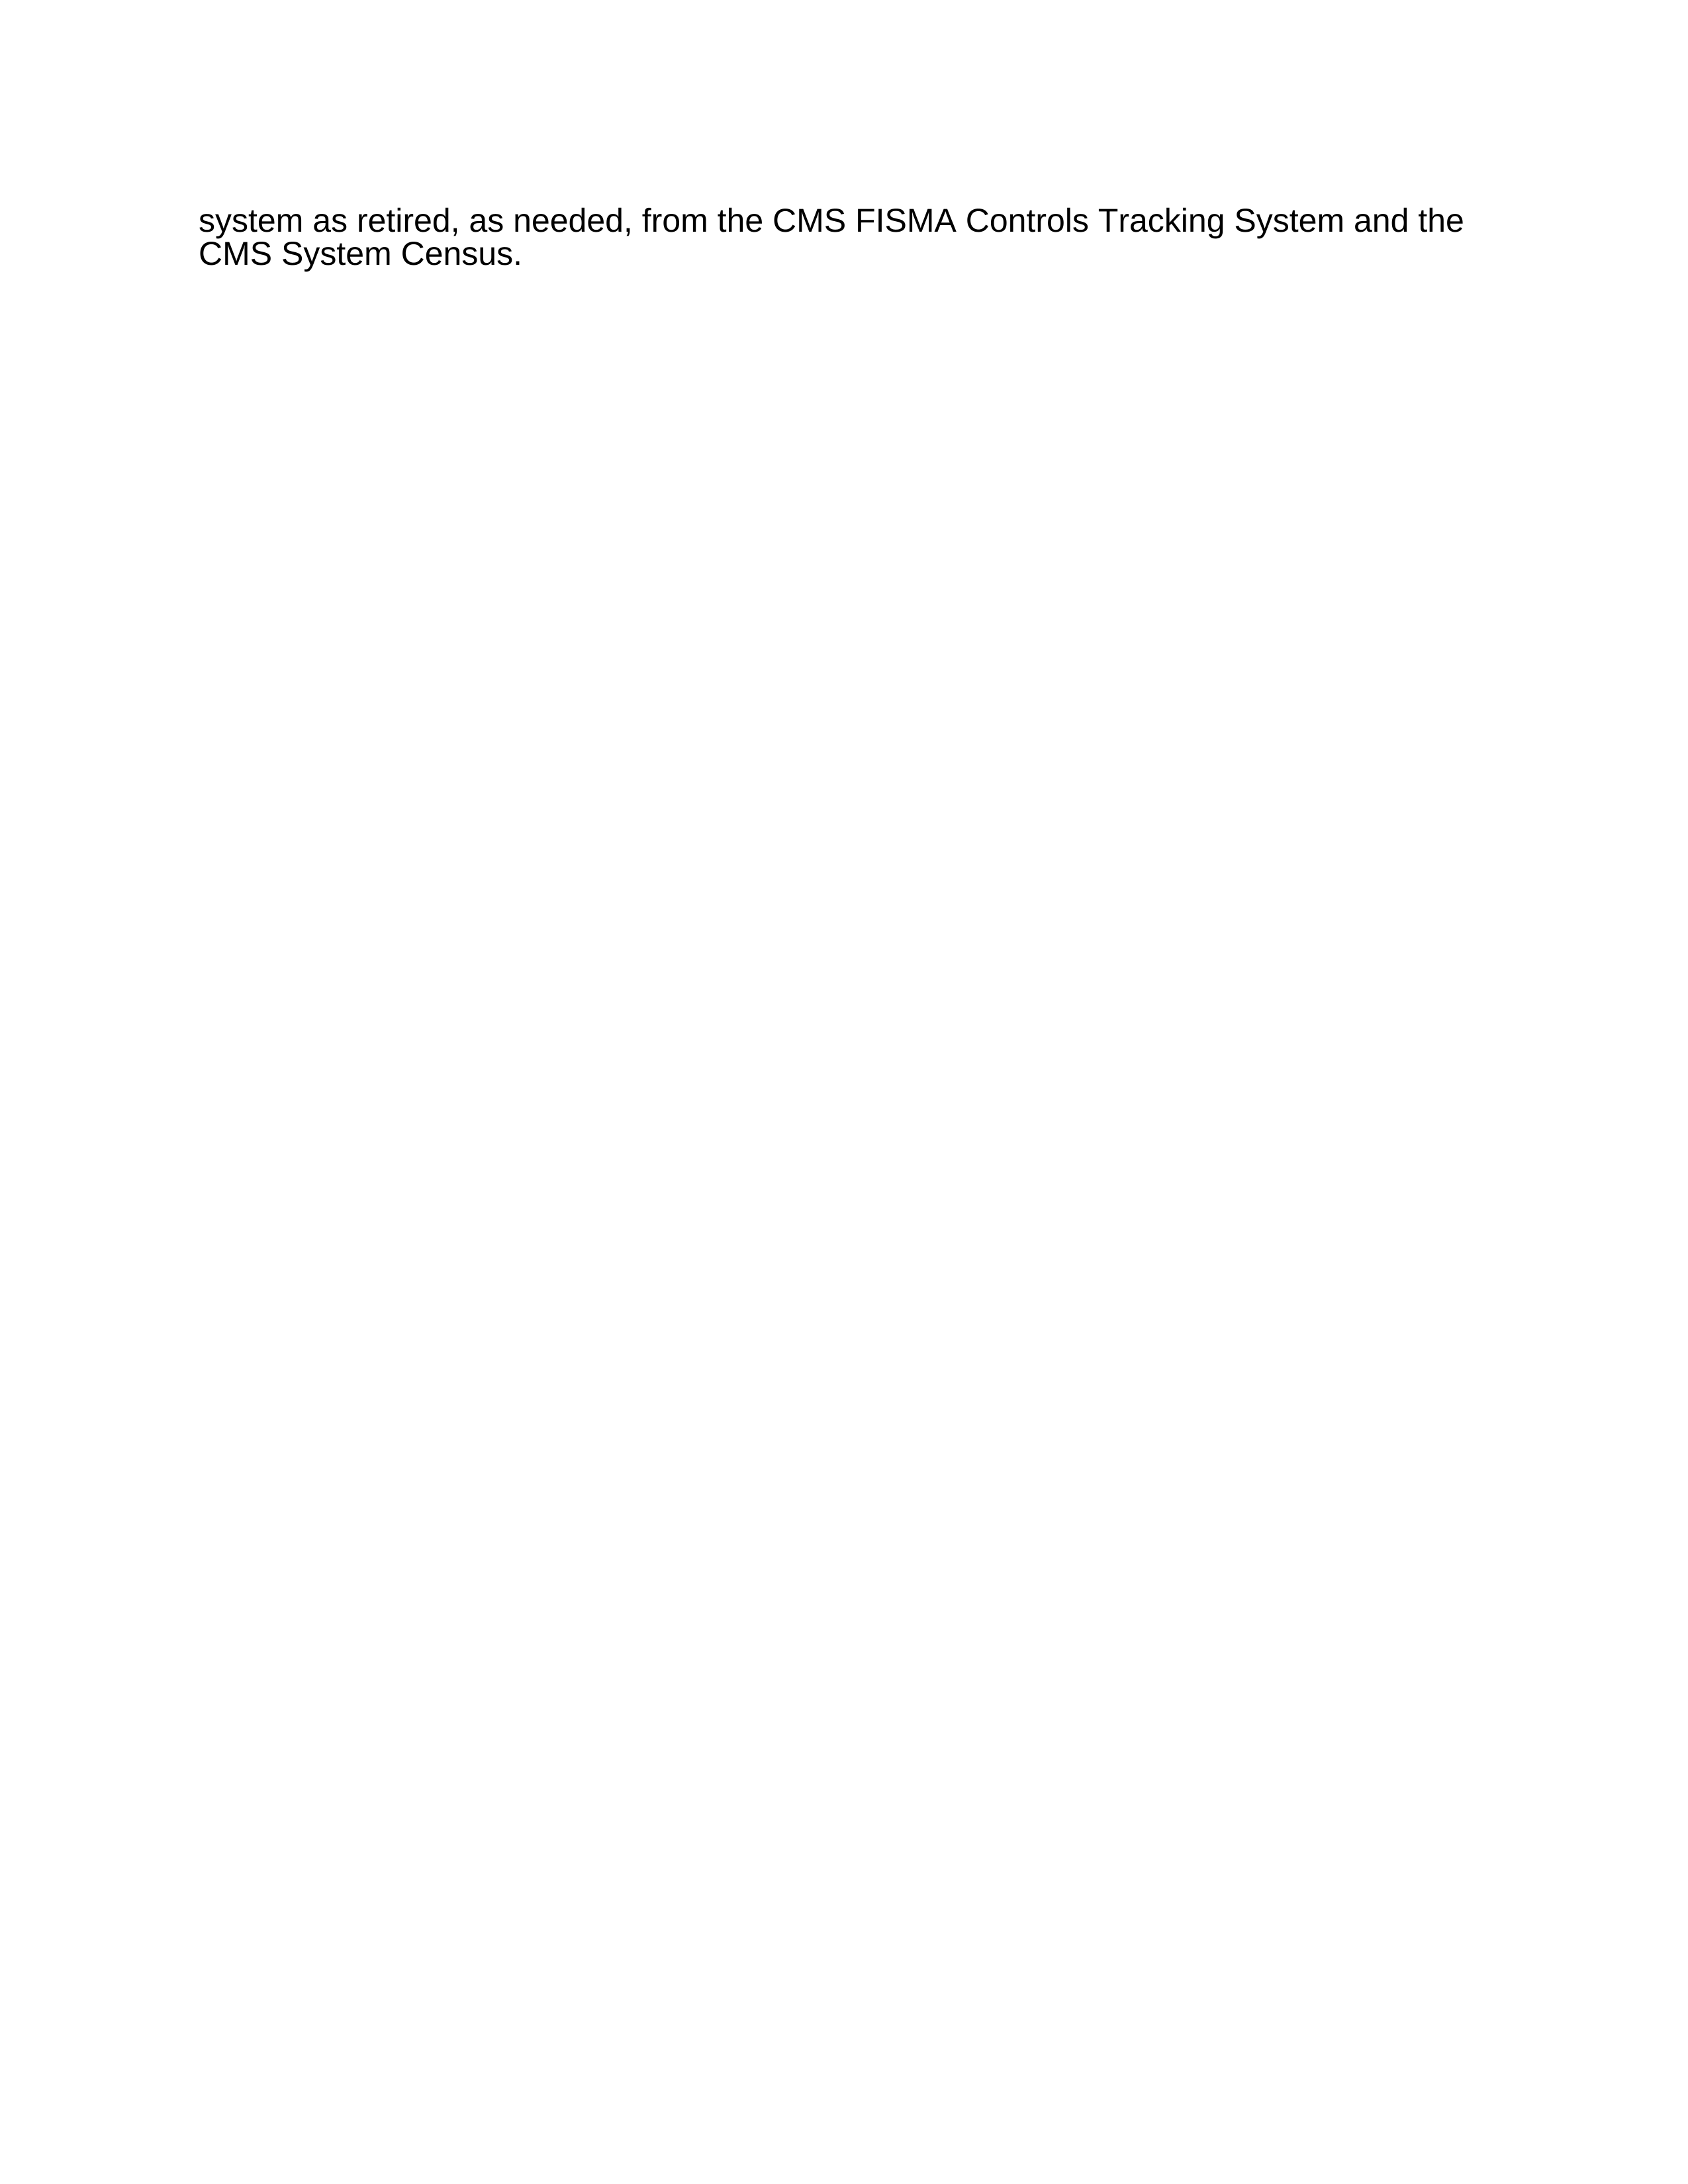

In [9]:
image_df = PdfToImage().transform(DocToPdf().setOutputCol("content").transform(doc_example_df))
for r in image_df.select("image").collect():
    display_image(r.image)


## **🔎Extract text using `DocToText` transformer**


In [10]:
doc_to_text = DocToText()
doc_to_text.setInputCol("content")
doc_to_text.setOutputCol("text")

result = doc_to_text.transform(doc_example_df)

## **🔎Display result DataFrame**

In [19]:
result.show()

+--------------------+--------------------+------+--------------------+---------+-------+
|                path|    modificationTime|length|                text|exception|pagenum|
+--------------------+--------------------+------+--------------------+---------+-------+
|file:/content/Dis...|2022-06-09 09:02:...|299223|
Disposition Chec...|     null|      0|
+--------------------+--------------------+------+--------------------+---------+-------+



##**🔎Display extracted text**

In [12]:
print("\n".join([row.text for row in result.select("text").collect()]))


Disposition Checklist
 
Purpose
The purpose of this document is to identify the required activities and approvals to retire an information system in compliance with CMS and federal laws and mandates. This checklist should be tailored based on the needs/situation of the program. Not all steps are applicable to every situation – please indicate on the form if a step was not applicable.
Disposition Planning Support
The CMS Technical Review Board (TRB) has provided an in-depth guide to help you plan the disposition of your technical elements at TRB Disposition Guidance.  You can also request a meeting with the TRB for individualized help with your disposition requirements and process. Contact them at cms-trb@cms.hhs.gov.
Checklist
Develop a System Disposition Plan which identifies the disposition activities, timeline, and key points of contact. The System Disposition Plan should address the timing of specific activities identified within this checklist.
Review and closeout any Plan of Act